In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym
plt.rcParams['figure.figsize'] = (15, 7)

In [17]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    argmax_action = np.argmax(q_values)
    probs = epsilon * np.ones(action_n) / action_n
    probs[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p = probs)
    return action

def discrete_state(state):
    bins = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    state = [max(-0.99, min(0.99, s)) for s in state]
    t = [bins[i] for i in np.digitize(state, bins)]
    return tuple(t)

class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.network = nn.Sequential(nn.Linear(self.state_dim, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, self.action_n)
                                     )
        self.softmax = nn.Softmax(dim = 0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-2)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, _input):
        return self.network(_input)
        
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        probs = self.softmax(logits).data.numpy()
        action = np.random.choice(self.action_n, p = probs)
        return action
    
    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)
                
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        pred_actions = self.forward(elite_states)
        
        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        
def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state = env.reset()

    for _ in range(max_len):
        trajectory['states'].append(state)
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
    
        if visualize:
            time.sleep(0.01)
            env.render()

        if done:
            break
    
    return trajectory

In [19]:
def MonteCarlo(env, episode_n, t_max = 500, gamma = 0.99):
    action_n = env.action_space.n
    
    Q = {}
    N = {}
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        states, actions, rewards = [], [], []
        
        state = discrete_state(env.reset())
        
        for t in range(t_max):
            states.append(state)

            if state not in Q :
                Q[state] = np.zeros(action_n)
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            actions.append(action)
            
            state, reward, done, _ = env.step(action)
            state = discrete_state(state)
            rewards.append(reward)
            
            if done:
                break
            
        total_rewards.append(sum(rewards))
        
        G = np.zeros(len(rewards))
        G[-1] = rewards[-1]
        
        for t in range(len(rewards) - 2, -1, -1):
            G[t] = rewards[t] + gamma * G[t + 1]
        
        for t in range(len(rewards)):
            
            if states[t] not in N:
                N[states[t]] = np.zeros(action_n)
                
            Q[states[t]][actions[t]] += (G[t] - Q[states[t]][actions[t]]) / (N[states[t]][actions[t]] + 1)
            N[states[t]][actions[t]] += 1
        
        epsilon -= 1 / episode_n
        
    return total_rewards, Q, N


def SARSA(env, episode_n, t_max = 1000, gamma = 0.99, alpha = 0.5):
    
    action_n = env.action_space.n
    
    Q = {}
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        total_reward = 0
        state = discrete_state(env.reset())
        
        if state not in Q :
            Q[state] = np.zeros(action_n)
        
        action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
        
        for t in range(t_max):

            next_state, reward, done, _ = env.step(action)
            next_state = discrete_state(next_state)
            
            next_action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            total_reward += reward
            
            if next_state not in Q :
                Q[next_state] = np.zeros(action_n)
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            state = next_state
            action = next_action
            
            if done:
                break
            
        total_rewards.append(total_reward)
        epsilon -= 1 / episode_n
        
    return total_rewards, Q

def Qlearning(env, episode_n, t_max = 500, gamma = 0.99, alpha = 0.5):
    
    action_n = env.action_space.n
    
    Q = {}
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        total_reward = 0
        state = discrete_state(env.reset())

        for t in range(t_max):
            
            if state not in Q :
                Q[state] = np.zeros(action_n)
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            
            next_state = discrete_state(next_state)
            
            if next_state not in Q:
                Q[next_state] = np.zeros(action_n)

            Q[state][action] += alpha * (reward + gamma * Q[next_state][np.argmax(Q[next_state])] - Q[state][action])
            
            state = next_state
            
            if done:
                break
            
        total_rewards.append(total_reward)
        epsilon -= 1 / episode_n
        
    return total_rewards, Q

def DCM(env, episode_n):
    state_dim = 4
    action_n = 2
    
    agent = CEM(state_dim, action_n)
    q_param = 0.9
    iteration_n = episode_n
    trajectory_n = 20
    
    rewards = []

    for iteration in range(iteration_n):

        #policy evaluation
        trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
        total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]

        rewards.append(np.mean(total_rewards))

        #policy improvement
        quantile = np.quantile(total_rewards, q_param)
        elite_trajectories = []
        for trajectory in trajectories:
            total_reward = np.sum(trajectory['rewards'])
            if total_reward > quantile:
                elite_trajectories.append(trajectory)
                
        if len(elite_trajectories) > 0:
            agent.fit(elite_trajectories)

    return rewards

<Axes: >

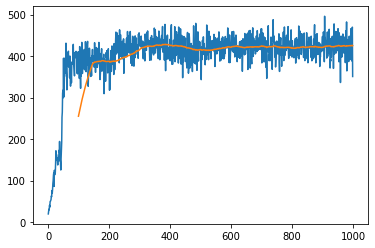

In [24]:
env = gym.make('CartPole-v1')
total_rewards_dcm = DCM(env, episode_n = 1000)
plt.plot(total_rewards_dcm)
pd.Series(total_rewards_dcm).rolling(100).mean().plot()

<Axes: >

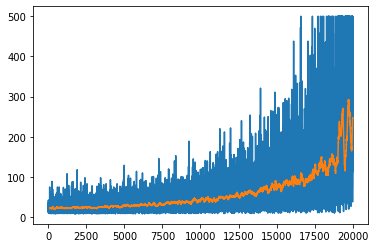

In [23]:
env = gym.make('CartPole-v1')

total_rewards_q, Q = Qlearning(env, episode_n = 20000)

plt.plot(total_rewards_q)
pd.Series(total_rewards_q).rolling(100).mean().plot()

<Axes: >

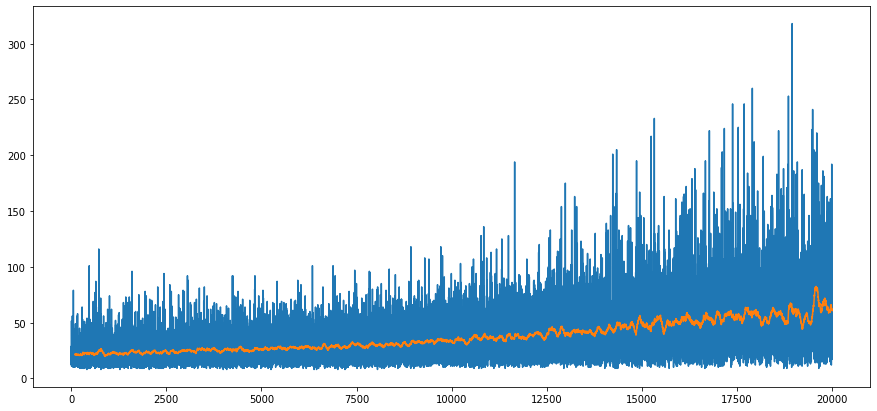

In [29]:
env = gym.make('CartPole-v1')

total_rewards_sarsa, Q = SARSA(env, episode_n = 20000)

plt.plot(total_rewards_sarsa)
pd.Series(total_rewards_sarsa).rolling(100).mean().plot()

<Axes: >

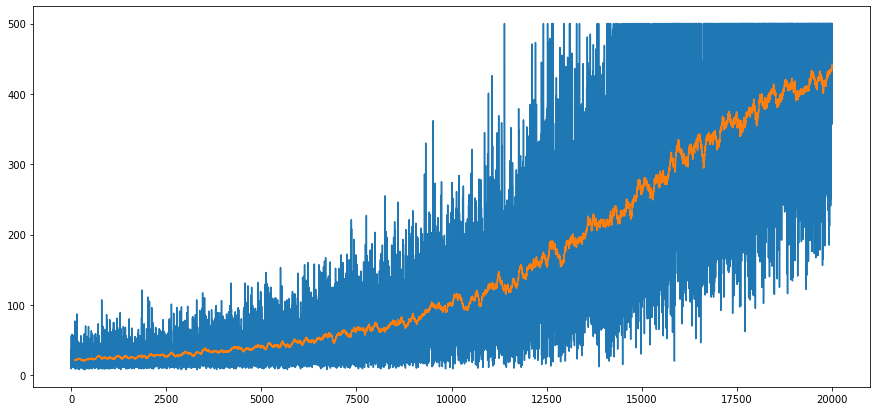

In [30]:
env = gym.make('CartPole-v1')

total_rewards_mc, Q, N = MonteCarlo(env, episode_n = 20000)

plt.plot(total_rewards_mc)
pd.Series(total_rewards_mc).rolling(100).mean().plot()

Text(0.5, 1.0, 'Smoothed with rolling window of 100')

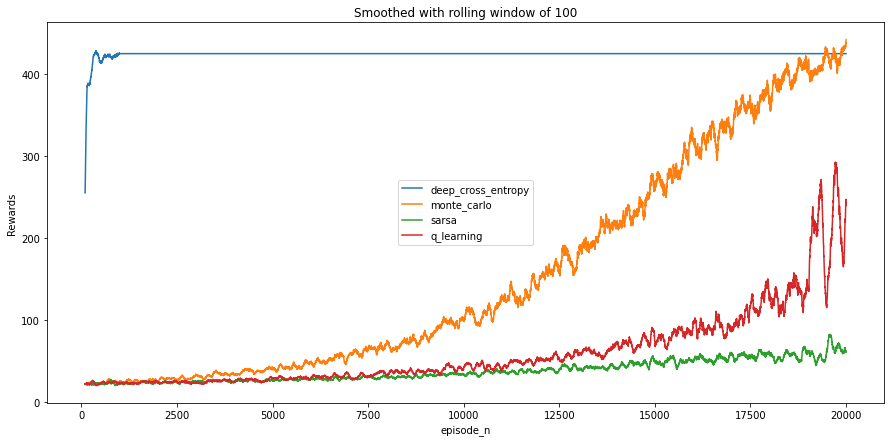

In [57]:
x_axis = np.arange(0, 20000, 1)
plt.plot(x_axis, np.concatenate([pd.Series(total_rewards_dcm).rolling(100).mean().to_numpy(), np.repeat(pd.Series(total_rewards_dcm).rolling(100).mean().iloc[-1], len(x_axis) - len(total_rewards_dcm))]), label = 'deep_cross_entropy')
plt.plot(x_axis, pd.Series(total_rewards_mc).rolling(100).mean(), label = 'monte_carlo')
plt.plot(x_axis, pd.Series(total_rewards_sarsa).rolling(100).mean(), label = 'sarsa')
plt.plot(x_axis, pd.Series(total_rewards_q).rolling(100).mean(), label = 'q_learning')
plt.ylabel("Rewards")
plt.xlabel("episode_n")
plt.legend(loc = 'best')
plt.title("Smoothed with rolling window of 100")

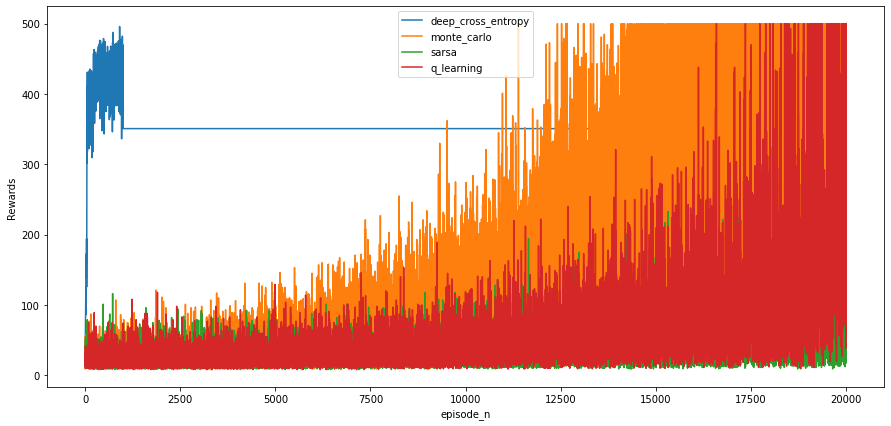

In [56]:
x_axis = np.arange(0, 20000, 1)
plt.plot(x_axis, np.concatenate([total_rewards_dcm, np.repeat(total_rewards_dcm[-1], len(x_axis) - len(total_rewards_dcm))]), label = 'deep_cross_entropy')
plt.plot(x_axis, total_rewards_mc, label = 'monte_carlo')
plt.plot(x_axis, total_rewards_sarsa, label = 'sarsa')
plt.plot(x_axis, total_rewards_q, label = 'q_learning')
plt.ylabel("Rewards")
plt.xlabel("episode_n")
plt.legend(loc = 'best')

array([    nan,     nan,     nan, ..., 425.074, 425.074, 425.074])